In [106]:
import numpy as np
import os
import pandas as pd
from sklearn import svm
import time
import warnings
warnings.filterwarnings("ignore")

# Data processing

## Data Description


Due to the limited computational resource, we focus on chromosome 16 with only one alternative allele.<br>
We transform data into datafram. Each column is the position of SNPs and each row is the sample ID. We category total 26 groups into 6 ancestry group and replace each ancestry group with number 1-6.<br>
We only care about where mutation appear for each sample. So, we replace 0 (homozygous reference) to 0 (no variant), and 1 or 2(heterozygous and homozygous non-reference) to 1 (variant) for each position through all samples.

In [2]:
%%bash

#file=/datasets/cs284-sp21-A00-public/ps2/ps2_pca.genotypes.vcf.gz

#zcat $file | head -253 | tail -1 > data/snps_sample.tab

#bcftools query -e'AF<0.01' -e'AF>0.99' -e'MAF>0.1' -f "%CHROM %POS [%GT\t]\n" $file | \
#  sed 's/0|0/0/g' | sed 's/0|1/1/g' | sed 's/1|0/1/g' | sed 's/1|1/2/g' | \
#  grep -v "|" \
#  > data/snps.tab

In [107]:
temp = []
with open("data/snps.tab", "r") as f:
    for line in f:
        #read line 
        sample = line.strip().split()
        temp.append(sample)
samples = []
with open("data/snps_sample.tab", "r") as f:
    for line in f:
        samples = line.strip().split()

In [108]:
cols = ["CHROM","POS"]
cols = cols+samples[9:]

In [109]:
snps = pd.DataFrame(temp, columns=cols)

In [110]:
snps["SNPs_POS"] = "chr"+snps["CHROM"] +":"+snps["POS"]

In [111]:
snps = snps.iloc[:,2:]
snps = snps.set_index('SNPs_POS')

In [112]:
snps = snps.transpose()

In [113]:
temp = []
temp2 = []
with open("data/ps2_reference_labels.csv", "r") as f:
    for line in f:
        s, pop = line.strip().split(",")
        temp.append(pop)
        temp2.append(s)

In [114]:
snps = snps.drop(["NA10847","NA18923","NA19700"])

In [115]:
snps["group_id"] = temp

In [116]:
snps.head()

SNPs_POS,chr16:88165,chr16:95254,chr16:97354,chr16:101263,chr16:103423,chr16:103456,chr16:105320,chr16:105444,chr16:107275,chr16:110165,...,chr16:90125947,chr16:90127080,chr16:90132786,chr16:90134325,chr16:90141355,chr16:90141477,chr16:90148979,chr16:90149922,chr16:90163275,group_id
HG00096,0,0,0,1,1,0,1,1,1,1,...,0,0,0,0,2,2,2,0,2,GBR
HG00097,0,0,0,2,2,0,2,2,2,2,...,0,0,0,0,2,2,2,0,2,GBR
HG00099,0,0,0,2,2,0,2,2,2,2,...,0,1,0,0,0,2,2,1,2,GBR
HG00100,0,0,0,1,1,0,1,1,1,1,...,0,1,0,0,1,2,2,1,1,GBR
HG00101,0,0,0,2,2,0,2,2,2,2,...,0,1,0,0,1,2,2,1,1,GBR


In [117]:
list(snps. index) == temp2

True

In [118]:
def ancestry_type(row):
    if row.group_id in ["ACB","ASW"]:
        return "Admixed African"
    elif row.group_id in ["GIH","BEB","ITU"]:
        return "South Asian"
    elif row.group_id in ["CDX","CHB","CHS","JPT","KHV"]:
        return "East Asian"
    elif row.group_id in ["CEU","FIN","GBR","IBS","TSI"]:
        return "European"
    elif row.group_id in ["CLM","MXL","PEL","PJL","PUR","STU"]:
        return "American"
    elif row.group_id in ["LWK","MSL","YRI","ESN","GWD"]:
        return "African"
    else:
        return None
snps["ancestry_group"] = snps.apply(ancestry_type, axis = 1)

In [119]:
def code_group(row):
    if row.ancestry_group == "Admixed African":
        return 1
    elif row.ancestry_group == "South Asian":
        return 2
    elif row.ancestry_group == "East Asian":
        return 3
    elif row.ancestry_group == "European":
        return 4
    elif row.ancestry_group == "American":
        return 5
    elif row.ancestry_group == "African":
        return 6
    else:
        return 0

In [120]:
snps["class"] = snps.apply(code_group, axis = 1)

In [121]:
snps.head()

SNPs_POS,chr16:88165,chr16:95254,chr16:97354,chr16:101263,chr16:103423,chr16:103456,chr16:105320,chr16:105444,chr16:107275,chr16:110165,...,chr16:90132786,chr16:90134325,chr16:90141355,chr16:90141477,chr16:90148979,chr16:90149922,chr16:90163275,group_id,ancestry_group,class
HG00096,0,0,0,1,1,0,1,1,1,1,...,0,0,2,2,2,0,2,GBR,European,4
HG00097,0,0,0,2,2,0,2,2,2,2,...,0,0,2,2,2,0,2,GBR,European,4
HG00099,0,0,0,2,2,0,2,2,2,2,...,0,0,0,2,2,1,2,GBR,European,4
HG00100,0,0,0,1,1,0,1,1,1,1,...,0,0,1,2,2,1,1,GBR,European,4
HG00101,0,0,0,2,2,0,2,2,2,2,...,0,0,1,2,2,1,1,GBR,European,4


## Data split

We randomly split the data into 75% train and 25% test.

In [122]:
from sklearn.model_selection import train_test_split

In [123]:
#Select the columns of features
X=snps.loc[: , (snps.columns != 'group_id') & (snps.columns != 'ancestry_group') & (snps.columns != 'class')]

In [124]:
X = X.applymap(lambda x: 1 if int(x) >0 else 0)
X.head()

SNPs_POS,chr16:88165,chr16:95254,chr16:97354,chr16:101263,chr16:103423,chr16:103456,chr16:105320,chr16:105444,chr16:107275,chr16:110165,...,chr16:90125731,chr16:90125947,chr16:90127080,chr16:90132786,chr16:90134325,chr16:90141355,chr16:90141477,chr16:90148979,chr16:90149922,chr16:90163275
HG00096,0,0,0,1,1,0,1,1,1,1,...,0,0,0,0,0,1,1,1,0,1
HG00097,0,0,0,1,1,0,1,1,1,1,...,0,0,0,0,0,1,1,1,0,1
HG00099,0,0,0,1,1,0,1,1,1,1,...,0,0,1,0,0,0,1,1,1,1
HG00100,0,0,0,1,1,0,1,1,1,1,...,0,0,1,0,0,1,1,1,1,1
HG00101,0,0,0,1,1,0,1,1,1,1,...,0,0,1,0,0,1,1,1,1,1


In [125]:
#Select the class column
Y=snps.loc[: , snps.columns == 'class']
Y.head()

SNPs_POS,class
HG00096,4
HG00097,4
HG00099,4
HG00100,4
HG00101,4


In [126]:
x_train, x_test, y_train, y_test = train_test_split(X, Y)

# Methods

In [127]:
#chi2
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#random
import random
#PCA
from sklearn.decomposition import PCA
## info_gain
from collections import defaultdict
from math import log

## chi2 selection

Chi-square test is used for categorical features in a dataset. We calculate Chi-square between each feature and the target and select the desired number of features with best Chi-square scores. It determines if the association between two categorical variables of the sample would reflect their real association in the population.

In [128]:
def chi2_selection(x_train,x_test,y_train,y_test,num):
    test = SelectKBest(score_func=chi2, k=num).fit(x_train, y_train)
    X_select_index = test.get_support(indices=True)
    return X_select_index

## Info Gain

Information gain is the reduction in entropy or surprise by transforming a dataset and is often used in training decision trees. Information gain is calculated by comparing the entropy of the dataset before and after a transformation.

In [129]:
def calcShannonEnt(Y):
    numEntries = len(Y)
    labelCounts = defaultdict(int)
    for label in Y:
        labelCounts[label] += 1
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries
        shannonEnt -= prob * log(prob, 2)
    return shannonEnt

def calcInfoGain(dataset,Y):
    baseEntropy = calcShannonEnt(Y)
    InfoGain_list = []
    for i in range(dataset.shape[0]):
        subset_list = [[],[],[]]
        for j in range(dataset.shape[1]):
            subset_list[int(dataset[i,j])].append(j)
        newEntropy = 0.0
        splitInfo = 0.0
        for value in [0,1,2]:
            if len(subset_list[value])==0:
                continue
            prob = len(subset_list[value])/float(dataset.shape[1])
            newEntropy += prob * calcShannonEnt(Y[subset_list[value]])
            splitInfo += -prob * log(prob, 2)
        infoGain = baseEntropy - newEntropy
        if (splitInfo == 0):
            continue
        infoGainRatio = infoGain / splitInfo
        InfoGain_list.append(infoGainRatio)
    return InfoGain_list

In [130]:
InfoGain_list = calcInfoGain(x_train.to_numpy().transpose(),y_train.to_numpy().transpose()[0])
rank_infoGain = np.array(InfoGain_list).argsort()

## Random Select

random select certain number of SNPs 

In [131]:
def random_select(k):
    return random.sample(range(28622), k)

# Classification Results

In [132]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.ensemble import  AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB

import time

## SVM

In [133]:
def simple_SVM(X,Y,test_X,test_Y,method='svm_linear'):
    #time0=time.time()
    if method=='svm_linear' or method==0:
        clf = svm.SVC(kernel='linear')
    elif method=='KNeighbors' or method==1:
        clf = KNeighborsClassifier()
    elif method=='LogisticRegression' or method==2:
        clf = LogisticRegression(penalty='l2')
    elif method=='RandomForest' or method==3:
        clf = RandomForestClassifier(n_estimators=8)
    elif method=='DecisionTree' or method==4:
        clf = tree.DecisionTreeClassifier()
    elif method=='AdaBoost' or method==5:
        clf = AdaBoostClassifier()
    elif method=='Bayes' or method==6:
        clf = MultinomialNB(alpha=0.01)
    else:
        print('Not implied!')
        return None
    
    clf.fit(X,Y)
    #print('Train time:',int(time.time()-time0))
    train_score = clf.score(X, Y)
    test_score = clf.score(test_X, test_Y)
    #print('train acc:',train_score)
    #print('test acc:',test_score)
    return [train_score,test_score]

In [134]:
def classfier_code(num):
    if num == 0:
        return "svm_linear"
    elif num==1:
        return "KNeighbors"
    elif num==2:
        return "LogisticRegression"
    elif num==3:
        return "RandomForest"
    elif num==4:
        return "DecisionTree"
    elif num==5:
        return "AdaBoost"
    elif num==6:
        return "Bayes"
    else:
        return None

## Comparison

## PCA

In [135]:
from sklearn.decomposition import PCA

time1=time.time()

pca = PCA(n_components=4).fit(x_train)
train_pca = pca.transform(x_train)
test_pca = pca.transform(x_test)

pca_data = simple_SVM(train_pca,y_train,test_pca,y_test)[0]

In [162]:
pca_data

0.8837333333333334

In [136]:
import matplotlib.pyplot as plt

In [137]:
result = []
for num in [50,500,1000,2000,5000]:
    for clf_num in [0,2]:
        temp = []
        temp.append(num)
        temp.append(classfier_code(clf_num))
        #chi2
        idx = chi2_selection(x_train,x_test,y_train,y_test,num)
        chi2_r = simple_SVM(x_train.iloc[:,idx],y_train,x_test.iloc[:,idx],y_test,clf_num)
        temp.append(chi2_r[1])
        #info gain
        info_r = simple_SVM(x_train.iloc[:,rank_infoGain[-num:]],y_train,x_test.iloc[:,rank_infoGain[-num:]],y_test,clf_num)
        temp.append(info_r[1])
        #random
        rl = random_select(num)
        random_r = simple_SVM(x_train.iloc[:,rl],y_train,x_test.iloc[:,rl],y_test,clf_num)
        temp.append(random_r[1])
        result.append(temp)

In [138]:
df = pd. DataFrame(result,columns = ["#SNPs", "classifier","chi2_accuracy","info_gain_accuracy","random_accuracy"])

In [139]:
df

,#SNPs,classifier,chi2_accuracy,info_gain_accuracy,random_accuracy
0,50,svm_linear,0.656550,0.674121,0.691693
1,50,LogisticRegression,0.634185,0.661342,0.675719
2,500,svm_linear,0.730032,0.782748,0.768371
3,500,LogisticRegression,0.746006,0.785942,0.773163
4,1000,svm_linear,0.782748,0.825879,0.811502
5,1000,LogisticRegression,0.765176,0.793930,0.808307
6,2000,svm_linear,0.835463,0.835463,0.843450
7,2000,LogisticRegression,0.811502,0.808307,0.813099
8,5000,svm_linear,0.870607,0.851438,0.853035
9,5000,LogisticRegression,0.840256,0.822684,0.832268


In [140]:
original = []
for clf_num in [0,2]:
    temp = simple_SVM(x_train,y_train,x_test,y_test,clf_num)
    t = []
    t.append(28622)
    t.append(classfier_code(clf_num))
    t.append(0)
    t.append(0)
    t.append(0)
    t.append(temp[1])
    original.append(t)

In [141]:
original

[[28622, 'svm_linear', 0, 0, 0, 0.854632587859425],
 [28622, 'LogisticRegression', 0, 0, 0, 0.8226837060702875]]

In [142]:
df_p = df

In [143]:
df_p = df
df_p["all_accuracy"] = [0]*len(df_p) 

In [144]:
a_series = pd.Series(original[0], index = df_p.columns)
df_p = df_p.append(a_series, ignore_index=True)
a_series = pd.Series(original[1], index = df_p.columns)
df_p = df_p.append(a_series, ignore_index=True)
df_p

,#SNPs,classifier,chi2_accuracy,info_gain_accuracy,random_accuracy,all_accuracy
0,50,svm_linear,0.656550,0.674121,0.691693,0.000000
1,50,LogisticRegression,0.634185,0.661342,0.675719,0.000000
2,500,svm_linear,0.730032,0.782748,0.768371,0.000000
3,500,LogisticRegression,0.746006,0.785942,0.773163,0.000000
4,1000,svm_linear,0.782748,0.825879,0.811502,0.000000
5,1000,LogisticRegression,0.765176,0.793930,0.808307,0.000000
6,2000,svm_linear,0.835463,0.835463,0.843450,0.000000
7,2000,LogisticRegression,0.811502,0.808307,0.813099,0.000000
8,5000,svm_linear,0.870607,0.851438,0.853035,0.000000
9,5000,LogisticRegression,0.840256,0.822684,0.832268,0.000000


In [145]:
df[df["classifier"]=="svm_linear"].set_index("#SNPs")

,classifier,chi2_accuracy,info_gain_accuracy,random_accuracy,all_accuracy
#SNPs,,,,,
50,svm_linear,0.656550,0.674121,0.691693,0
500,svm_linear,0.730032,0.782748,0.768371,0
1000,svm_linear,0.782748,0.825879,0.811502,0
2000,svm_linear,0.835463,0.835463,0.843450,0
5000,svm_linear,0.870607,0.851438,0.853035,0


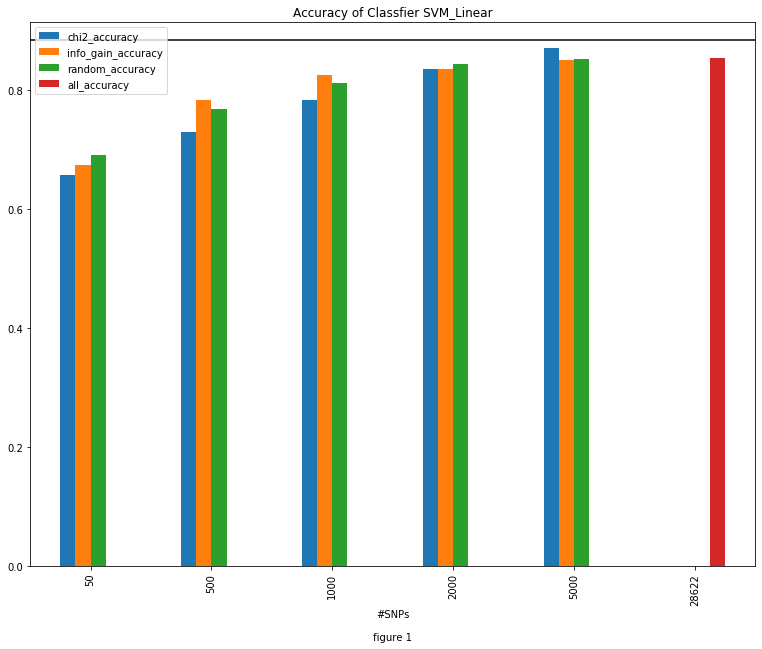

In [146]:
df2 = df_p[df_p["classifier"]=="svm_linear"].set_index("#SNPs")
df2.plot.bar()
plt.title("Accuracy of Classfier SVM_Linear")
#plt.suptitle('figure 1', y=-0.01)
plt.axhline(y=pca_data, color='black', linestyle='-')
plt.xlabel("#SNPs\n\nfigure 1")
plt.rcParams["figure.figsize"] = (13,10)
plt.savefig('SVM_acc.png')
plt.show()

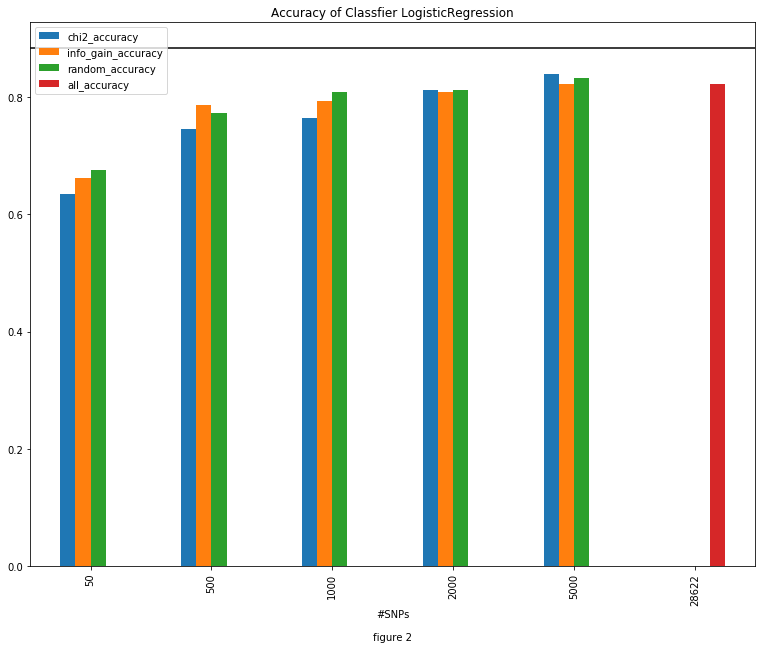

In [147]:
df2 = df_p[df_p["classifier"]=="LogisticRegression"].set_index("#SNPs")
df2.plot.bar()
plt.title("Accuracy of Classfier LogisticRegression")
#plt.rcParams["figure.figsize"] = (5,5)
plt.axhline(y=pca_data, color='black', linestyle='-')
plt.xlabel("#SNPs\n\nfigure 2")
plt.savefig('LR_acc.png')
plt.show()

# Discussion

## overlap

In [148]:
chi2_idx = chi2_selection(x_train,x_test,y_train,y_test,1000)
info_idx = rank_infoGain[-1000:]

In [149]:
intersection_set = set.intersection(set(chi2_idx), set(info_idx))
overlap_idx = list(intersection_set)

In [150]:
len(overlap_idx)

66

In [151]:
overlap = []
for clf_num in range(7):
    temp = []
    temp.append(classfier_code(clf_num))
    idx = chi2_selection(x_train,x_test,y_train,y_test,num)
    acc = simple_SVM(x_train.iloc[:,overlap_idx],y_train,x_test.iloc[:,overlap_idx],y_test,clf_num)
    temp.append(acc[1])
    overlap.append(temp)

In [152]:
df_overlap = pd. DataFrame(overlap,columns = ["classfier","accuracy"])

In [153]:
df_overlap

,classfier,accuracy
0,svm_linear,0.699681
1,KNeighbors,0.656550
2,LogisticRegression,0.722045
3,RandomForest,0.640575
4,DecisionTree,0.602236
5,AdaBoost,0.452077
6,Bayes,0.701278


## classification_report

In [154]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np

In [155]:
def predict_value(X,Y,test_X,test_Y):
    clf = LogisticRegression(penalty='l2') 
    clf.fit(X,Y)
    return clf.predict(test_X)

In [156]:
target_names = ["Admixed-African","South-Asian","East-Asian","European","American","African"]

In [157]:
y_pred = predict_value(x_train,y_train,x_test,y_test)
report = classification_report(y_test, y_pred, target_names=target_names)

## Plot

In [158]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [159]:
def plot_classification_report(cr, ax, fig, title_f='Classification report ', with_avg_total=False, cmap=plt.cm.Blues):
    lines = cr.split('\n')
    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) - 3)]:
        #print(line)
        t = line.split()
        if len(t)>3:
            classes.append(t[0])
            v = [float(x) for x in t[1: len(t) - 1]]
            plotMat.append(v)
    if with_avg_total:
        aveTotal = lines[len(lines) - 3].split()
        classes.append('avg/total')
        vAveTotal = [float(x) for x in aveTotal[2:len(aveTotal) - 1]]
        plotMat.append(vAveTotal)

    im = ax.imshow(plotMat, interpolation='nearest', cmap=cmap)
    ax.set_title(title_f)
    fig.colorbar(im, ax=ax)
    
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    ax.set_xticks(x_tick_marks)
    ax.set_xticklabels(['precision', 'recall', 'f1-score'], rotation=45)
    ax.set_yticks(y_tick_marks)
    ax.set_yticklabels(classes)
    ax.set_ylabel('Classes')
#     ax.set_xlabel('Measures')

                 precision    recall  f1-score   support

Admixed-African       0.82      0.19      0.31        48
    South-Asian       0.59      0.80      0.68        60
     East-Asian       0.99      1.00      1.00       116
       European       0.90      0.99      0.95       114
       American       0.88      0.71      0.78       160
        African       0.77      0.99      0.87       128

       accuracy                           0.84       626
      macro avg       0.83      0.78      0.76       626
   weighted avg       0.85      0.84      0.82       626



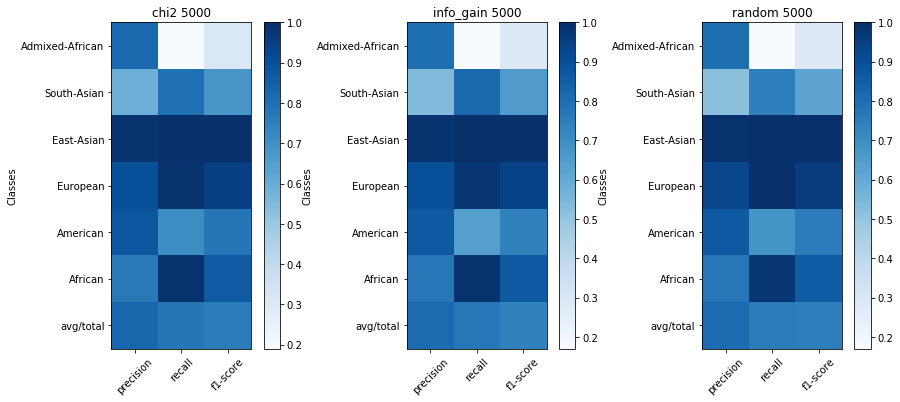

In [166]:
nums = [5000] # TODO select these number, maybe use 10 50 100?

fig, axs = plt.subplots(len(nums), 3, squeeze=False, figsize=(15, 6 * len(nums)))
# plt.tight_layout()
for idx, num in enumerate(nums):
    #chi2
    chi2_idx = chi2_selection(x_train,x_test,y_train,y_test,num)
    y_pred_chi2 = predict_value(x_train.iloc[:,chi2_idx],y_train,x_test.iloc[:,chi2_idx],y_test)
    report = classification_report(y_test, y_pred_chi2, target_names=target_names)
    plot_classification_report(report, axs[idx][0], fig, title_f=f"chi2 {num}", with_avg_total=True)
    print(report)
    #info_gain
    info_idx = rank_infoGain[-num:]
    y_pred = predict_value(x_train.iloc[:,info_idx],y_train,x_test.iloc[:,info_idx],y_test)
    report_info = classification_report(y_test, y_pred, target_names=target_names)
    plot_classification_report(report_info, axs[idx][1], fig, title_f=f"info_gain {num}", with_avg_total=True)
    #random
    rl = random_select(num)
    y_pred_r = predict_value(x_train.iloc[:, rl],y_train,x_test.iloc[:, rl],y_test)
    report_r = classification_report(y_test, y_pred_r, target_names=target_names)
    plot_classification_report(report_r, axs[idx][2], fig, title_f=f"random {num}", with_avg_total=True)
plt.show()
fig.savefig('heatmap.png')

In [164]:
print(report_info)

                 precision    recall  f1-score   support

Admixed-African       0.80      0.17      0.28        48
    South-Asian       0.54      0.82      0.65        60
     East-Asian       0.99      1.00      1.00       116
       European       0.90      0.98      0.94       114
       American       0.87      0.64      0.74       160
        African       0.77      0.99      0.87       128

       accuracy                           0.82       626
      macro avg       0.81      0.77      0.74       626
   weighted avg       0.84      0.82      0.81       626



# Summary